# Naive DDC approach for NRT Channelizer

- https://ieeexplore.ieee.org/document/7314417
- https://ieeexplore.ieee.org/document/7879676
- https://www.researchgate.net/publication/351827578_High_Efficient_Polyphase_Digital_Down_Converter_on_FPGA
- http://courses.itee.uq.edu.au/elec3004/2012s1/_lectures/ELEC3004.Lecture14.pdf
- http://www.ee.ic.ac.uk/hp/staff/dmb/courses/DSPDF/01200_Polyphase.pdf
- Fredric J. Harris, Multirate Signal Processing for Communication Systems, https://ieeexplore.ieee.org/book/9429990

In [1]:
import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib widget
#%matplotlib qt

Generate some wideband noise with some RFI lines as a test signal

In [2]:
fs = 3.7e9
N_samples = 1024**2
amp = 2 * np.sqrt(2)
noise_power = 0.0000001 * fs / 2
n = np.arange(N_samples)
time = n / float(fs)

In [3]:
modulation_index = 1000
mod = modulation_index * np.cos(2*np.pi*2e4*time)
carrier = amp * np.sin(2*np.pi*1.25e9*time + mod)

#plt.figure()
#plt.plot(time, mod)
#plt.figure()
#plt.plot(time, carrier)

In [4]:
rng = np.random.default_rng()
noise = rng.normal(scale=np.sqrt(noise_power), size=time.shape)

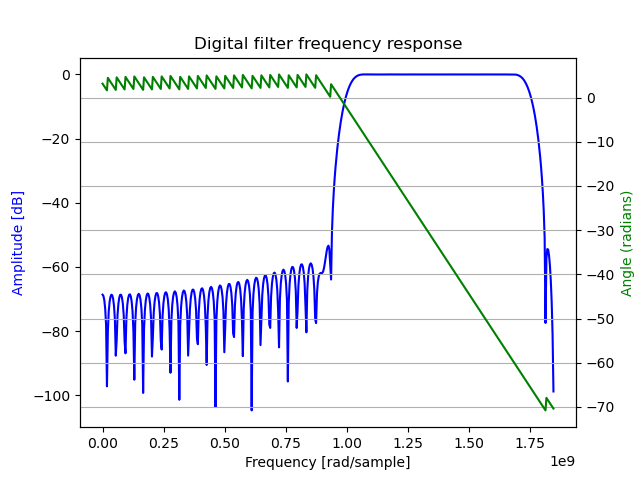

In [5]:
numtaps = 100
BF_feed_filter = scipy.signal.firwin(numtaps, [1e9, 1.75e9] , width=None, window='hamming', pass_zero=False, scale=True, nyq=None, fs=fs)

w,h = scipy.signal.freqz(BF_feed_filter, fs=fs)
fig, ax1 = plt.subplots()

ax1.set_title('Digital filter frequency response')
ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid(True)
ax2.axis('tight')
plt.show()

In [6]:
noise = scipy.signal.lfilter(BF_feed_filter, 1, noise, axis=-1, zi=None)
#plt.figure()
#plt.plot(time, noise)

In [7]:
#plt.figure()
#f, t, Sxx = scipy.signal.stft(noise, fs)
#plt.pcolormesh(t, f, np.abs(Sxx), shading='gouraud')
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
#plt.show()

In [8]:
x = carrier + noise
#plt.figure()
#plt.plot(time, x)


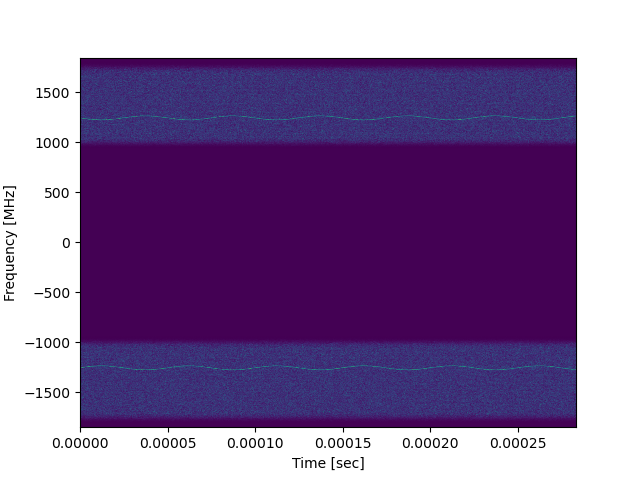

In [9]:
fig, ax1 = plt.subplots()
f, t, Sxx = scipy.signal.stft(x, fs, return_onesided=False, nperseg=1024)
ax1.pcolormesh(t, (scipy.fft.fftshift(f))/1e6, scipy.fft.fftshift(np.abs(Sxx), axes=0), shading='gouraud')
ax1.set_ylabel('Frequency [MHz]')
ax1.set_xlabel('Time [sec]')
plt.show()

Multiplication by a complex sine, sample per sample, to shift the frequency of interest to DC


In [10]:
DDC_step_len = 1024
F0 = 1.23e9
k0 = int(F0/fs*DDC_step_len)
F0 = k0/DDC_step_len * fs
L0 = np.exp(-2j*np.pi*k0*n/DDC_step_len)
#plt.figure()
#plt.plot(time, L0.real, time, L0.imag)

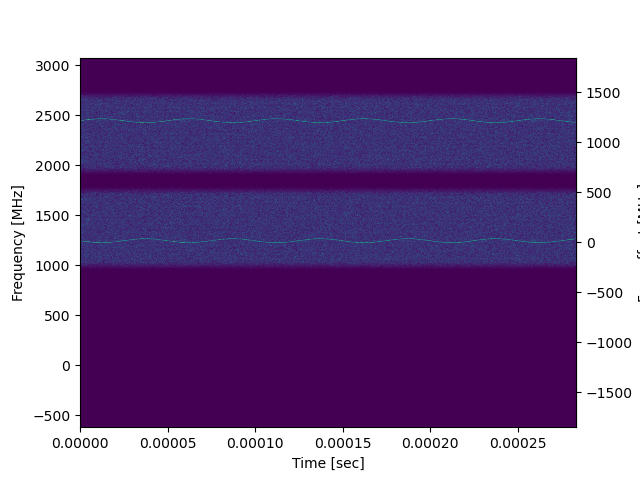

In [11]:
x_transposed = x * L0

fig, ax1 = plt.subplots()
f, t, Sxx = scipy.signal.stft(x_transposed, fs, return_onesided=False, nperseg=1024)
#f, t, Sxx = scipy.signal.spectrogram(x_transposed, fs)
ax1.pcolormesh(t, (F0 + scipy.fft.fftshift(f))/1e6, scipy.fft.fftshift(np.abs(Sxx), axes=0), shading='gouraud')
ax1.set_ylabel('Frequency [MHz]')
ax1.set_xlabel('Time [sec]')
secax = ax1.secondary_yaxis('right', functions=(lambda f: f-F0/1e6,
                                                lambda f: f+F0/1e6))
secax.set_ylabel('Freq offset [MHz]')

plt.show()

Low-Pass filter to select the band of interest, now centered on DC.

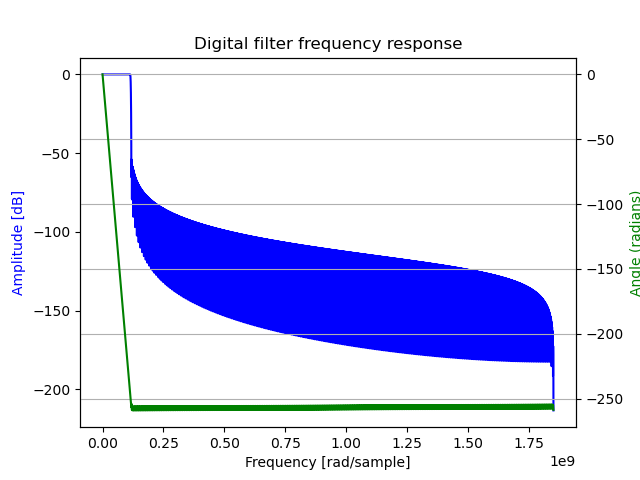

In [12]:
decimation = 16
numtaps = 10*256
LP_filter = scipy.signal.firwin(numtaps, fs/2/decimation , width=None, window='hamming', pass_zero=True, scale=True, nyq=None, fs=fs)

w,h = scipy.signal.freqz(LP_filter, worN=8192, fs=fs)
fig, ax1 = plt.subplots()

ax1.set_title('Digital filter frequency response')
ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid(True)
ax2.axis('tight')
plt.show()

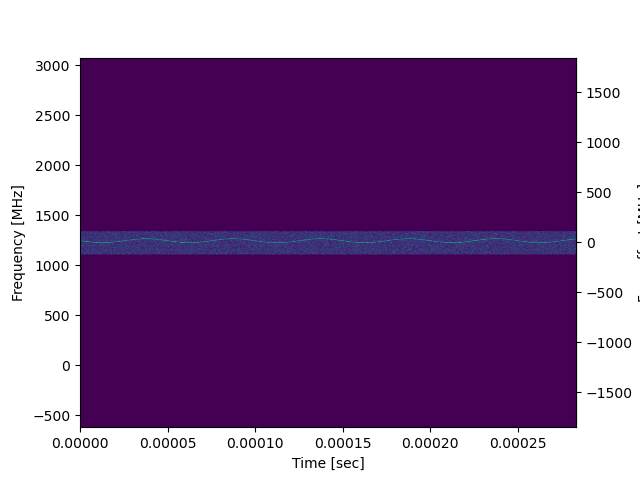

In [13]:
x_transposed_filtered = scipy.signal.lfilter(LP_filter, 1, x_transposed, axis=-1, zi=None)


fig, ax1 = plt.subplots()
f, t, Sxx = scipy.signal.stft(x_transposed_filtered, fs, return_onesided=False, nperseg=1024)
#f, t, Sxx = scipy.signal.spectrogram(x_transposed, fs)
ax1.pcolormesh(t, (F0 + scipy.fft.fftshift(f))/1e6, scipy.fft.fftshift(np.abs(Sxx), axes=0), shading='gouraud')
ax1.set_ylabel('Frequency [MHz]')
ax1.set_xlabel('Time [sec]')
secax = ax1.secondary_yaxis('right', functions=(lambda f: f-F0/1e6,
                                                lambda f: f+F0/1e6))
secax.set_ylabel('Freq offset [MHz]')

plt.show()

Decimate signal now that out of band of interest power was removed

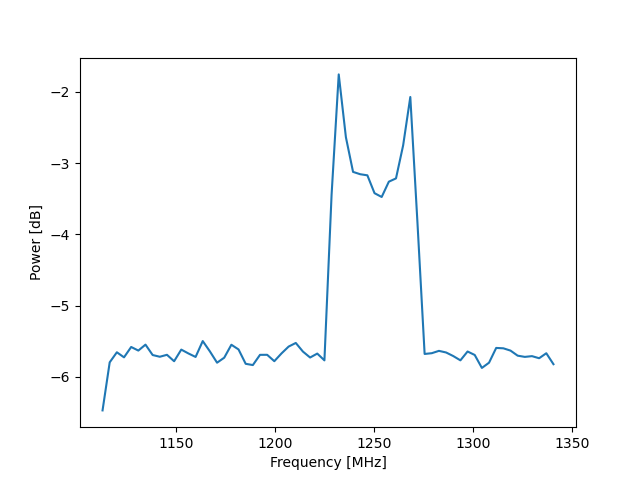

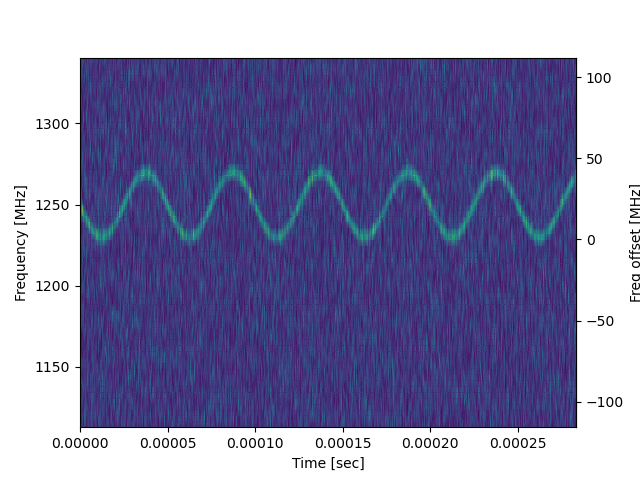

In [14]:
x_transposed_filtered_decimated = x_transposed_filtered[::decimation]

fig, ax1 = plt.subplots()
f, t, Sxx = scipy.signal.stft(x_transposed_filtered_decimated, fs/decimation, return_onesided=False, nperseg=1024/decimation)
#f, t, Sxx = scipy.signal.spectrogram(x_transposed, fs)
ax1.pcolormesh(t, (F0 + scipy.fft.fftshift(f))/1e6, scipy.fft.fftshift(np.abs(Sxx), axes=0), shading='gouraud')
ax1.set_ylabel('Frequency [MHz]')
ax1.set_xlabel('Time [sec]')
secax = ax1.secondary_yaxis('right', functions=(lambda f: f-F0/1e6,
                                                lambda f: f+F0/1e6))
secax.set_ylabel('Freq offset [MHz]')

acced_spec = (np.abs(Sxx)**2).mean(axis=1)
fig, ax1 = plt.subplots()
ax1.plot((F0 + scipy.fft.fftshift(f))/1e6, scipy.fft.fftshift(10*np.log10(acced_spec), axes=0))
ax1.set_xlabel('Frequency [MHz]')
ax1.set_ylabel('Power [dB]')

plt.show()